In [3]:
import random; random.seed(0)
import numpy as np; np.random.seed(0)
import torch; torch.manual_seed(0)

from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.manifold import TSNE

from matplotlib import pyplot as plt
import matplotlib.cm as cm

from tqdm import tqdm
from pathlib import Path

import einops, umap
from sklearn.metrics import silhouette_score, silhouette_samples

import seaborn as sns; sns.set()

batch_size = 128

## Dataset

For our project we rely on the Cifar-10 dataset, which consists on examples of images with size 32x32 in rgb channels. To evaluate the studied approaches we use the torchvision library which contains the latter dataset splited into training and dev in a balanced fashion accross all its 10 classes, resulting in 50K examples for training and 10K for develompent.

Since in this project we are looking for evaluate the performance of some feature selection techinques such as Autoencoders, we will construct a third split from the dev set (test) to evaluate in an unbiased way the models performance. The test set, will be constructed sampling ~100 instances of each class from the development set.

In [2]:
def load_dataset(batch_size: int = 64) -> tuple[DataLoader, DataLoader]:

    '''
        Load the MNIST dataset and return the train and dev dataloaders.
        batch_size: the batch size for the dataloaders iterators
    '''

    transform = transforms.Compose(
      [transforms.ToTensor(),
      ])

    train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader( train_data, batch_size=batch_size, shuffle=True )

    test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    val_data, test_data = torch.utils.data.random_split(test_data, [int(0.9*len(test_data)), int(0.1*len(test_data))])
    

    dev_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)    
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


    # convert dict to sorted list
    class_mapping = [ z[0] for z in sorted(list(train_data.class_to_idx.items()), key=lambda x: x[1])]

    return train_loader, dev_loader, test_loader, class_mapping

train_loader, dev_loader, test_loader, class_mapping = load_dataset(batch_size = batch_size)

Files already downloaded and verified
Files already downloaded and verified


(0.0, 15.0)

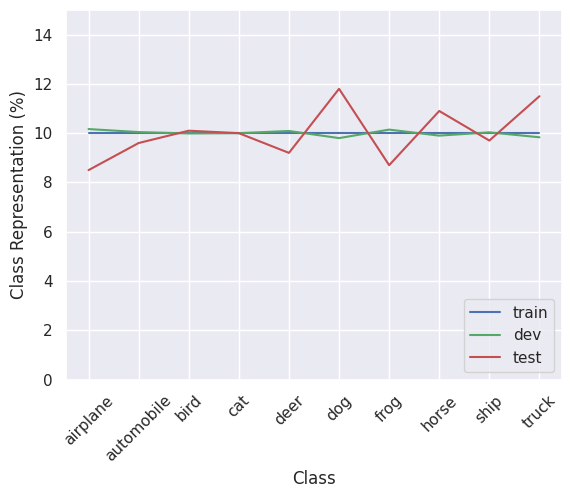

In [3]:
def get_relative_freqs(loader: DataLoader) -> list[float]:

    '''
        Return the relative frequencies of the classes in the dataset.
        loader: the dataloader to use
    '''

    freqs = [0] * 10
    for _, labels in loader:
        for label in labels:
            freqs[label.item()] += 1
    freqs = [freq*100 / sum(freqs) for freq in freqs]
    return freqs


fig, ax = plt.subplots()

ax.plot([i for i in get_relative_freqs(train_loader)], label='train', c='b', linestyle="-")
ax.plot([i for i in get_relative_freqs(dev_loader)], label='dev', c='g', linestyle="-")
ax.plot([i for i in get_relative_freqs(test_loader)], label='test',c='r', linestyle="-")
ax.legend( loc='lower right')
ax.set_ylabel('Class Representation (%)')
ax.set_xlabel('Class')

ax.set_xticks(np.arange(len(class_mapping)))
ax.set_xticklabels(class_mapping)

# Set x label rotation
plt.xticks(rotation=45)
plt.ylim(0, 15)

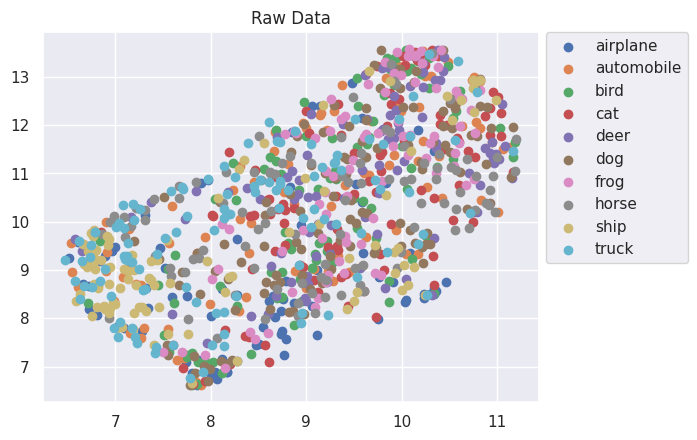

In [4]:
def plot_projection(loader: DataLoader, n_components: int, model: torch.nn.Module = None, source: str = 'Raw Data', reduction: str = 'umap' ) -> None:

    '''
        Plot the projection of the data in the dataloader using TSNE.
        
        loader: the dataloader to use
        n_components: the number of components to use in the projection
        source: the source of the data (used in the title)
        model: the model to use to project the data into a latent space (if None, the raw data is used)
        reduction: the reduction method to use (tsne or umap)

    '''

    example = []
    label = []
    for images, labels in loader:
        
        label += [labels.numpy()]
        
        if model is None:
            example += [images.view(images.shape[0], -1).numpy()]
        else:
            encoding = model(images.to(model.device), get_encoding=True).detach().cpu()
            example += [encoding.numpy()]
    
    example = np.concatenate(example, axis=0)
    label = np.concatenate(label)
    
    if example.shape[-1] > n_components:
        if reduction == 'tsne':
            t_sne = TSNE(n_components=n_components)
            example = t_sne.fit_transform(example)
        elif reduction == 'umap':
            reducer = umap.UMAP(n_neighbors = 50, min_dist=0.03)
            example = reducer.fit_transform(example)

    for clase in range(10):
        plt.scatter(example[label == clase, 0], example[label == clase, 1], label=class_mapping[clase])
    
    plt.legend()

    plt.legend(bbox_to_anchor=(1., 1.02))
    plt.title(source)
    plt.show()

plot_projection(test_loader, 2)

At this point we can see that projecting the raw representation of our data does not seems to depict any distance relation in the space of representation obtained when the image mappings are flattened into a vector.

We then try to use the idea introduced by the Autoencoders and PCA at first, which underlies on determining two functions $f$ and $g$, the encoder and decoder respectively. The firstone learns to maps the inputs of the model into a dense representation which contains a condensed transforation of it.
This lattent representation is interpolated back into the original space by the decoder function and compared to the input of the model to propagate the errors made by both  $f$ and $g$ by using gradient descent-like algorithm. 
This way of determining $f$ and $g$ used for iterative and learning process as in neural networks, whereas with PCA we have:  $g = f^{-1}$ and these transformation matrices are obtained with a basis of ortonormal vectors asociated to the absolutly greater aigenvalues of the covariance matrix of features.

In our case, $f$ and $g$ will be convolutional operator-based models. We must notice that in the simple cases of Autoencoders, the models are prone to overfit the training set since, overlooking the relation of hyper-vectors in the neighborhod of the latent representation of the training examples when decoding them, which is kown as space (Non-)Regularity.


In [5]:
def init_weights(module: torch.nn.Module) -> None:
    
    if isinstance(module, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)
        
    elif isinstance(module, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.01)

        
class Encoder(torch.nn.Module):
    
        '''
            Encoder Module
            Applies a series of non-linear transformations to the input tensor to condense de information into a latent representation.
        '''
    
        def __init__(self, input_depth: int, hidden_dim: int) -> None:
    
            '''
                input_dim: amount of input features
                hidden_dim: rank of latent representation
            '''
    
            super(Encoder, self).__init__()
    
            self.input_dim = input_depth
            self.hidden_dim = hidden_dim
    
            self.encoder = torch.nn.Sequential( torch.nn.Conv2d(input_depth, 16, kernel_size=3, stride=2),
                                                torch.nn.ReLU(),
                                                #15x15 mapping
                                                    
                                                torch.nn.Conv2d(16, 16, kernel_size=3, padding='same'),
                                                torch.nn.ReLU(),
                                               
                                                torch.nn.Conv2d(16, 32, kernel_size=3, stride=2),
                                                torch.nn.ReLU(),
                                                #7x7 mapping
                                               
                                                torch.nn.Conv2d(32, 32, kernel_size=3, padding='same'),
                                                torch.nn.ReLU(),
                                               
                                                torch.nn.Conv2d(32, 64, kernel_size=3, stride=2),
                                                torch.nn.ReLU(),
                                                #3x3 mapping
                                               
                                                torch.nn.Flatten(),
                                                torch.nn.Linear(3*3*64, hidden_dim)
            )
        
        def forward(self, x: torch.Tensor) -> torch.Tensor:
            return self.encoder(x)

class Decoder(torch.nn.Module):

    '''
            Decoder Module
            Applies a series of non-linear transformations to the latent representation to reconstruct the input tensor. 
            Based in transposed convolutions to usample the image encoded by th encoder until reach the same size as the input.
    ''' 
     

    def __init__(self, output_depth: int, hidden_dim: int) -> None:

        '''
            input_dim: amount of input features
            hidden_dim: rank of latent representation
        '''

        super(Decoder, self).__init__()

        self.input_dim = output_depth
        self.hidden_dim = hidden_dim
        
        self.un_lantent = torch.nn.Sequential(torch.nn.Linear(hidden_dim, 64*3*3), torch.nn.ReLU())

        self.decoder = torch.nn.Sequential( torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
                                            torch.nn.ReLU(),
                                            # 7x7 mapping
                                            
                                            torch.nn.ConvTranspose2d(32, 32, 3, padding=1),
                                            torch.nn.ReLU(),

                                            torch.nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),
                                            torch.nn.ReLU(),
                                            # 15x15
                                            torch.nn.ConvTranspose2d(16, output_depth, kernel_size=3, stride=2, output_padding=1),
                                            torch.nn.Sigmoid(),

        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        x = self.un_lantent(x)
        x = einops.rearrange(x, 'b (c w h) -> b c w h', w = 3, h = 3)
        return self.decoder(x) 


class Autoencoder(torch.nn.Module):

    '''
        Autoencoder Module
        Combines the encoder and decoder modules to explore the family of f and g functions.
    '''

    def __init__(self, input_depth: int, hidden_dim: int) -> None:

        '''
            input_dim: amount of input features
            hidden_dim: rank of latent representation
        '''

        super().__init__()

        self.best_loss = None

        self.input_dim = input_depth
        self.hidden_dim = hidden_dim

        self.encoder = Encoder(input_depth, hidden_dim)
        self.decoder = Decoder(input_depth, hidden_dim)
        
        self.apply(init_weights)

        self.loss_criterion = torch.nn.MSELoss()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, x: torch.Tensor, get_encoding: bool = False) -> torch.Tensor:
             
            encode = self.encoder(x)
            if get_encoding:
                return encode
            
            decode = self.decoder(encode)
            return decode
    
    def save(self, path: str) -> None:
        torch.save(self.state_dict(), path)

    def load(self, path: str) -> None:
        self.load_state_dict(torch.load(path, map_location=self.device))

    def make_optimizer(self, lr: float, epoches: int, steps_per_epoch) -> None:
        
        opt = torch.optim.Adam(self.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, lr, epochs=epoches, 
                                              steps_per_epoch=steps_per_epoch)
        
        return opt , scheduler
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [6]:
def train_model( trainloader: DataLoader, devloader: DataLoader, epoches: int, output: str, 
                latent_rank: int, lr: float = 0.001) -> dict[str, list[float]]:


    Path(output).mkdir(parents=True, exist_ok=True)
    stats = {}

    model = Autoencoder(input_depth=3, hidden_dim=latent_rank)
    
    params_amount = sum([np.prod(param.shape) for param in model.parameters()])
    print('Total number of parameters: ', params_amount)

    optimizer, scheduler = model.make_optimizer(lr=lr, epoches=epoches, steps_per_epoch = len(trainloader))

    for epoch in range(epoches):

        running_stats = { 'loss': 0., 'metric': 0.}

        iter = tqdm(enumerate(trainloader, 0))
        iter.set_description(f'Epoch: {epoch:3d}')
        for j, data_batch in iter:

            torch.cuda.empty_cache()         
            inputs, _ = data_batch

            outputs = model(inputs.to(model.device))
            loss = model.loss_criterion(outputs, inputs.to(model.device))

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            stats['lr'] = stats.get('lr', []) + [get_lr(optimizer)] 

            # print statistics
            with torch.no_grad():

                running_stats['loss'] += loss.item()
                running_stats['metric'] += torch.nn.functional.mse_loss(outputs, inputs.to(model.device)).item()
                loss = running_stats['loss'] / (j+1)
                metric = running_stats['metric'] / (j+1)

                iter.set_postfix_str(f'loss:{loss:.3f} metric:{metric:.3f}') 

            if j == len(trainloader) - 1:

                model.eval()
                stats['loss'] = stats.get('loss', []) + [loss] 
                stats['metric'] = stats.get('metric', []) + [metric] 

                with torch.no_grad():

                    running_stats = {'preds': [], 'gt': []}
                    for k, data_batch_dev in enumerate(devloader, 0):
                        torch.cuda.empty_cache() 

                        inputs, _ = data_batch_dev
                        outputs = model(inputs.to(model.device))

                        running_stats['preds'] += outputs.detach().cpu()
                        running_stats['gt'] += inputs.detach().cpu()

                    stats['dev_loss'] = stats.get('dev_loss', []) + [model.loss_criterion(torch.cat(running_stats['preds']), torch.cat(running_stats['gt'])).item()]
                    stats['dev_metric'] = stats.get('dev_metric', []) + [torch.nn.functional.mse_loss(torch.cat(running_stats['preds']), torch.cat(running_stats['gt'])).item()]
                        
                if model.best_loss is None or model.best_loss > stats['dev_loss'][-1]:
                    torch.save(model.state_dict(), Path(output) / f'best_model_{latent_rank}.pt') 
                    model.best_loss = stats['dev_loss'][-1]

                iter.set_postfix_str(f"loss:{stats['loss'][-1]:.3f} metric:{stats['metric'][-1]:.3f} dev_loss: {stats['dev_loss'][-1]:.3f} dev_metric:{stats['dev_metric'][-1]:.3f}") 

    return stats

In [7]:

ranks = [2, 64, 128, 256, 1024, 2048]
histories = []

epoches = 24
lr = 1e-3
output = 'logs'

for latent_rank in ranks:
        
    print(f'training at rank {latent_rank}')
    histories += [train_model( trainloader = train_loader, devloader = dev_loader, epoches=epoches, 
                output = output, latent_rank = latent_rank, lr=lr)]

training at rank 2
Total number of parameters:  70805


Epoch:   0: : 391it [00:51,  7.53it/s, loss:0.064 metric:0.064 dev_loss: 0.059 dev_metric:0.059]
Epoch:   1: : 391it [00:18, 21.49it/s, loss:0.052 metric:0.052 dev_loss: 0.043 dev_metric:0.043]
Epoch:   2: : 391it [00:18, 21.08it/s, loss:0.040 metric:0.040 dev_loss: 0.040 dev_metric:0.040]
Epoch:   3: : 391it [00:19, 20.19it/s, loss:0.039 metric:0.039 dev_loss: 0.039 dev_metric:0.039]
Epoch:   4: : 391it [00:17, 21.92it/s, loss:0.039 metric:0.039 dev_loss: 0.039 dev_metric:0.039]
Epoch:   5: : 391it [00:17, 21.76it/s, loss:0.039 metric:0.039 dev_loss: 0.039 dev_metric:0.039]
Epoch:   6: : 391it [00:17, 21.93it/s, loss:0.039 metric:0.039 dev_loss: 0.039 dev_metric:0.039]
Epoch:   7: : 391it [00:17, 21.87it/s, loss:0.039 metric:0.039 dev_loss: 0.039 dev_metric:0.039]
Epoch:   8: : 391it [00:17, 21.85it/s, loss:0.039 metric:0.039 dev_loss: 0.039 dev_metric:0.039]
Epoch:   9: : 391it [00:17, 22.07it/s, loss:0.039 metric:0.039 dev_loss: 0.039 dev_metric:0.039]
Epoch:  10: : 391it [00:17, 21

training at rank 64
Total number of parameters:  142291


Epoch:   0: : 391it [00:20, 19.29it/s, loss:0.065 metric:0.065 dev_loss: 0.055 dev_metric:0.055]
Epoch:   1: : 391it [00:20, 18.95it/s, loss:0.042 metric:0.042 dev_loss: 0.032 dev_metric:0.032]
Epoch:   2: : 391it [00:22, 17.63it/s, loss:0.029 metric:0.029 dev_loss: 0.027 dev_metric:0.027]
Epoch:   3: : 391it [00:29, 13.17it/s, loss:0.025 metric:0.025 dev_loss: 0.024 dev_metric:0.024]
Epoch:   4: : 391it [00:21, 18.06it/s, loss:0.023 metric:0.023 dev_loss: 0.021 dev_metric:0.021]
Epoch:   5: : 391it [00:23, 16.92it/s, loss:0.021 metric:0.021 dev_loss: 0.021 dev_metric:0.021]
Epoch:   6: : 391it [00:21, 18.03it/s, loss:0.020 metric:0.020 dev_loss: 0.018 dev_metric:0.018]
Epoch:   7: : 391it [00:22, 17.59it/s, loss:0.017 metric:0.017 dev_loss: 0.017 dev_metric:0.017]
Epoch:   8: : 391it [00:21, 18.18it/s, loss:0.016 metric:0.016 dev_loss: 0.016 dev_metric:0.016]
Epoch:   9: : 391it [00:22, 17.51it/s, loss:0.016 metric:0.016 dev_loss: 0.015 dev_metric:0.015]
Epoch:  10: : 391it [00:22, 17

training at rank 128
Total number of parameters:  216083


Epoch:   0: : 391it [00:22, 17.51it/s, loss:0.060 metric:0.060 dev_loss: 0.047 dev_metric:0.047]
Epoch:   1: : 391it [00:33, 11.62it/s, loss:0.035 metric:0.035 dev_loss: 0.028 dev_metric:0.028]
Epoch:   2: : 391it [00:31, 12.49it/s, loss:0.026 metric:0.026 dev_loss: 0.024 dev_metric:0.024]
Epoch:   3: : 391it [00:41,  9.33it/s, loss:0.023 metric:0.023 dev_loss: 0.022 dev_metric:0.022]
Epoch:   4: : 391it [00:37, 10.43it/s, loss:0.022 metric:0.022 dev_loss: 0.021 dev_metric:0.021]
Epoch:   5: : 391it [00:26, 14.79it/s, loss:0.020 metric:0.020 dev_loss: 0.019 dev_metric:0.019]
Epoch:   6: : 391it [00:52,  7.38it/s, loss:0.019 metric:0.019 dev_loss: 0.018 dev_metric:0.018]
Epoch:   7: : 391it [00:22, 17.46it/s, loss:0.016 metric:0.016 dev_loss: 0.016 dev_metric:0.016]
Epoch:   8: : 391it [00:53,  7.26it/s, loss:0.015 metric:0.015 dev_loss: 0.015 dev_metric:0.015]
Epoch:   9: : 391it [00:47,  8.26it/s, loss:0.015 metric:0.015 dev_loss: 0.014 dev_metric:0.014]
Epoch:  10: : 391it [00:20, 19

training at rank 256
Total number of parameters:  363667


Epoch:   0: : 391it [00:24, 15.84it/s, loss:0.064 metric:0.064 dev_loss: 0.056 dev_metric:0.056]
Epoch:   1: : 391it [00:31, 12.36it/s, loss:0.041 metric:0.041 dev_loss: 0.030 dev_metric:0.030]
Epoch:   2: : 391it [00:37, 10.41it/s, loss:0.027 metric:0.027 dev_loss: 0.024 dev_metric:0.024]
Epoch:   3: : 391it [00:41,  9.46it/s, loss:0.022 metric:0.022 dev_loss: 0.020 dev_metric:0.020]
Epoch:   4: : 391it [00:24, 16.10it/s, loss:0.019 metric:0.019 dev_loss: 0.018 dev_metric:0.018]
Epoch:   5: : 391it [00:23, 16.56it/s, loss:0.018 metric:0.018 dev_loss: 0.017 dev_metric:0.017]
Epoch:   6: : 391it [00:29, 13.18it/s, loss:0.016 metric:0.016 dev_loss: 0.015 dev_metric:0.015]
Epoch:   7: : 391it [00:22, 17.49it/s, loss:0.015 metric:0.015 dev_loss: 0.015 dev_metric:0.015]
Epoch:   8: : 391it [00:26, 14.82it/s, loss:0.015 metric:0.015 dev_loss: 0.014 dev_metric:0.014]
Epoch:   9: : 391it [00:26, 15.00it/s, loss:0.014 metric:0.014 dev_loss: 0.014 dev_metric:0.014]
Epoch:  10: : 391it [00:21, 18

training at rank 1024
Total number of parameters:  1249171


Epoch:   0: : 391it [00:19, 19.67it/s, loss:0.059 metric:0.059 dev_loss: 0.042 dev_metric:0.042]
Epoch:   1: : 391it [00:22, 17.20it/s, loss:0.032 metric:0.032 dev_loss: 0.027 dev_metric:0.027]
Epoch:   2: : 391it [00:23, 16.97it/s, loss:0.025 metric:0.025 dev_loss: 0.023 dev_metric:0.023]
Epoch:   3: : 391it [00:21, 18.53it/s, loss:0.022 metric:0.022 dev_loss: 0.021 dev_metric:0.021]
Epoch:   4: : 391it [00:22, 17.05it/s, loss:0.019 metric:0.019 dev_loss: 0.018 dev_metric:0.018]
Epoch:   5: : 391it [00:20, 18.65it/s, loss:0.017 metric:0.017 dev_loss: 0.016 dev_metric:0.016]
Epoch:   6: : 391it [00:20, 19.39it/s, loss:0.015 metric:0.015 dev_loss: 0.016 dev_metric:0.016]
Epoch:   7: : 391it [00:23, 16.78it/s, loss:0.014 metric:0.014 dev_loss: 0.014 dev_metric:0.014]
Epoch:   8: : 391it [00:27, 14.19it/s, loss:0.013 metric:0.013 dev_loss: 0.013 dev_metric:0.013]
Epoch:   9: : 391it [00:42,  9.30it/s, loss:0.013 metric:0.013 dev_loss: 0.013 dev_metric:0.013]
Epoch:  10: : 391it [00:40,  9

training at rank 2048
Total number of parameters:  2429843


Epoch:   0: : 391it [00:22, 17.51it/s, loss:0.059 metric:0.059 dev_loss: 0.045 dev_metric:0.045]
Epoch:   1: : 391it [00:24, 15.99it/s, loss:0.032 metric:0.032 dev_loss: 0.026 dev_metric:0.026]
Epoch:   2: : 391it [00:19, 19.86it/s, loss:0.024 metric:0.024 dev_loss: 0.021 dev_metric:0.021]
Epoch:   3: : 391it [00:21, 18.16it/s, loss:0.021 metric:0.021 dev_loss: 0.019 dev_metric:0.019]
Epoch:   4: : 391it [00:19, 19.77it/s, loss:0.019 metric:0.019 dev_loss: 0.017 dev_metric:0.017]
Epoch:   5: : 391it [00:20, 19.11it/s, loss:0.016 metric:0.016 dev_loss: 0.016 dev_metric:0.016]
Epoch:   6: : 391it [00:23, 16.61it/s, loss:0.015 metric:0.015 dev_loss: 0.014 dev_metric:0.014]
Epoch:   7: : 391it [00:19, 19.79it/s, loss:0.014 metric:0.014 dev_loss: 0.013 dev_metric:0.013]
Epoch:   8: : 391it [00:23, 16.62it/s, loss:0.013 metric:0.013 dev_loss: 0.013 dev_metric:0.013]
Epoch:   9: : 391it [00:31, 12.60it/s, loss:0.012 metric:0.012 dev_loss: 0.012 dev_metric:0.012]
Epoch:  10: : 391it [00:31, 12

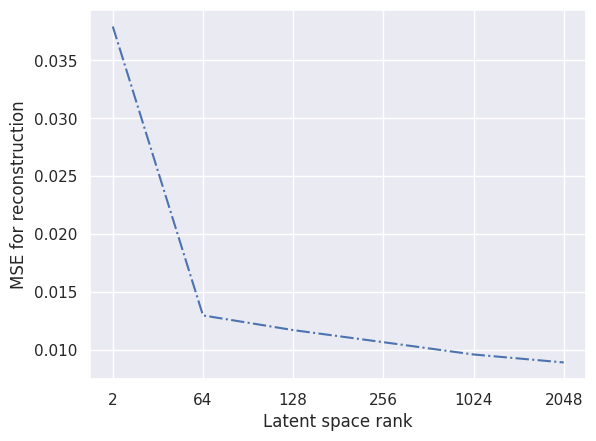

In [8]:
mse_dev = [min(batch['dev_loss']) for batch in histories]
fig, ax = plt.subplots()

ax.plot(mse_dev, label='train', c='b', linestyle="-.")
ax.set_ylabel('MSE for reconstruction')
ax.set_xlabel('Latent space rank')

ax.set_xticks(np.arange(len(mse_dev)))
ax.set_xticklabels(ranks)
 
plt.show()

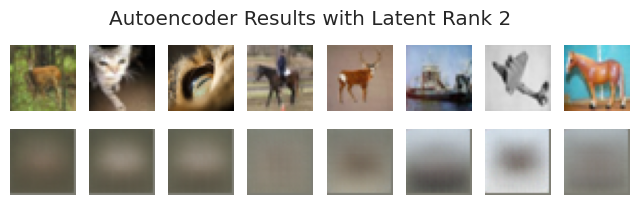

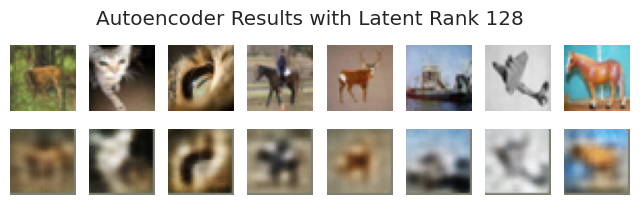

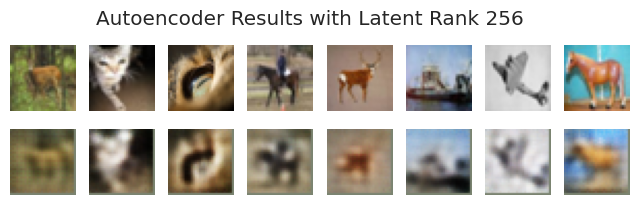

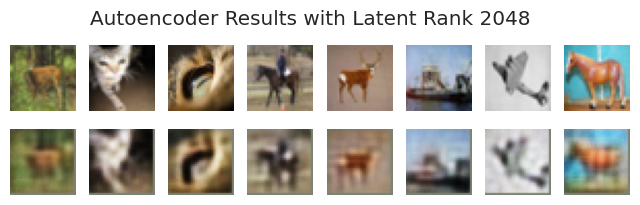

In [9]:

output = 'logs'# remove
sample = next(iter(test_loader))[0][np.random.choice(test_loader.batch_size, size=8)]

for rank in [2, 128, 256, 2048]:
    
    model = Autoencoder(input_depth=3, hidden_dim=rank)
    model.load(Path(output) / f'best_model_{rank}.pt')

    autoencode = model(sample.to(model.device)).detach().cpu().numpy()
    sample_plot = np.concatenate([sample.detach().cpu().numpy(), autoencode], axis=0)
    
    fig, axs = plt.subplots(2, 8, figsize=(8, 2))
    fig.suptitle(f'Autoencoder Results with Latent Rank {rank}', y=1.05)

    for i in range(2):
        for j in range(8): 
            ax = axs[i, j] 
            ax.imshow(sample_plot[8*i + j].transpose(1, 2, 0))
            ax.axis('off')

    plt.show()

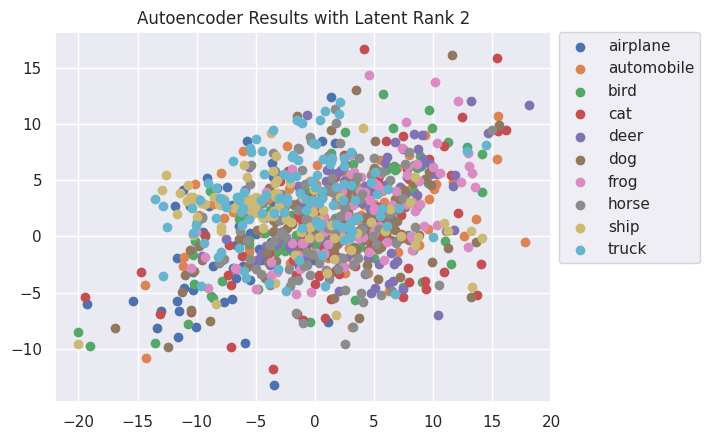

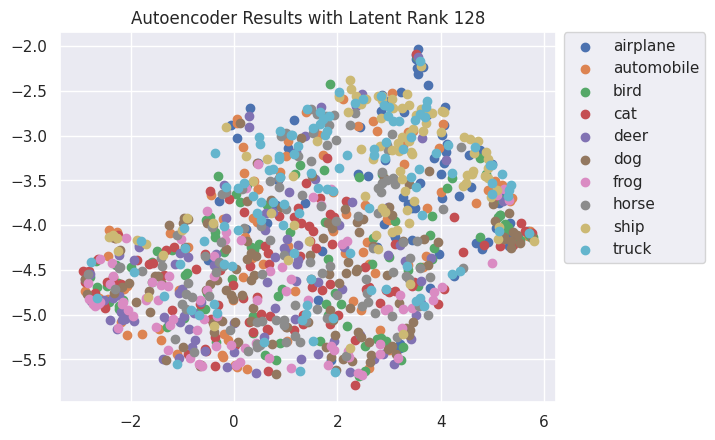

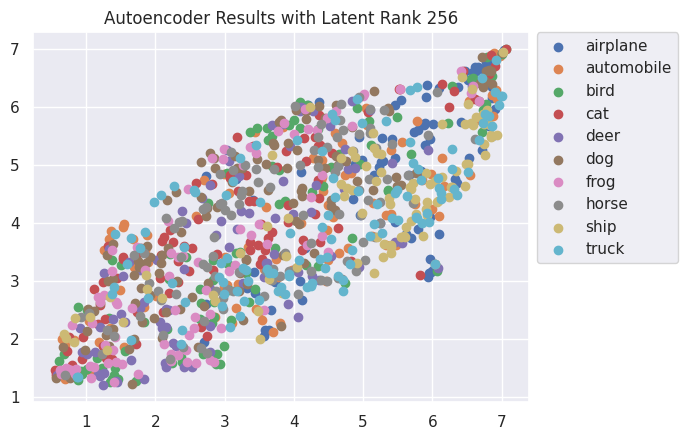

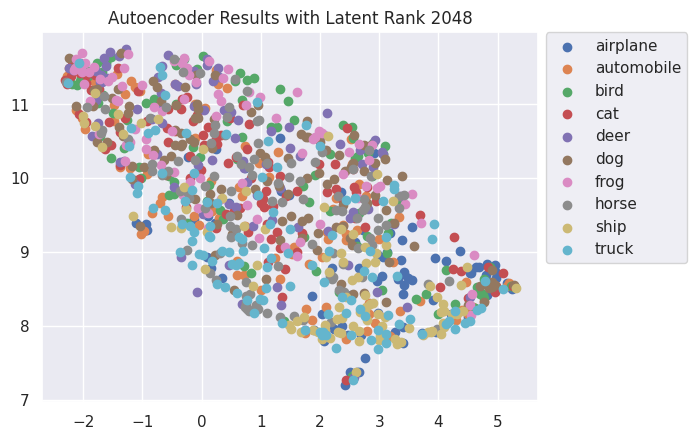

In [10]:
output = 'logs'# remove
for rank in [2, 128, 256, 2048]:

    model = Autoencoder(input_depth=3, hidden_dim=rank)
    model.load(Path(output) / f'best_model_{rank}.pt')
    plot_projection(loader = test_loader, n_components = 2, model = model, source = f'Autoencoder Results with Latent Rank {rank}', reduction = 'umap' )
    
    

Evaluation of compact representation in terms of cluser quality metrics

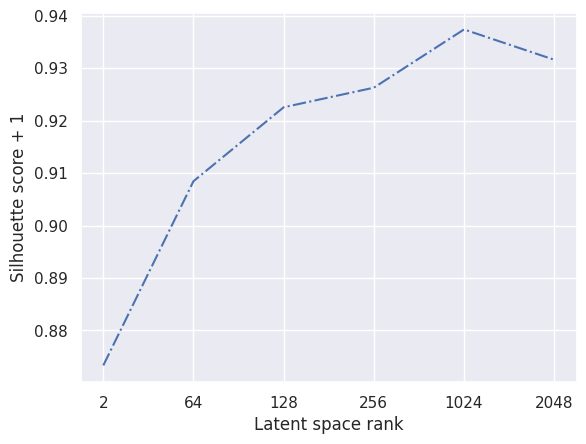

In [6]:
ranks = [2, 64, 128, 256, 1024, 2048]
output = 'logs'


metric = []
per_sample_metric = []

for rank in ranks:

    label, example = [], []
    model = Autoencoder(input_depth=3, hidden_dim=rank)
    model.load(Path(output) / f'best_model_{rank}.pt')

    for images, labels in test_loader:
        
        label += [labels.numpy()]
        
        encoding = model(images.to(model.device), get_encoding=True).detach().cpu()
        example += [encoding.numpy()]

    example = np.concatenate(example, axis=0)
    label = np.concatenate(label)

    metric += [silhouette_score(example, label) + 1]
    per_sample_metric += [silhouette_samples(example, label, metric='euclidean')]

fig, ax = plt.subplots()

ax.plot(metric, label='train', c='b', linestyle="-.")
ax.set_ylabel('Silhouette score + 1')
ax.set_xlabel('Latent space rank')

ax.set_xticks(np.arange(len(metric)))
ax.set_xticklabels(ranks)
 
plt.show()

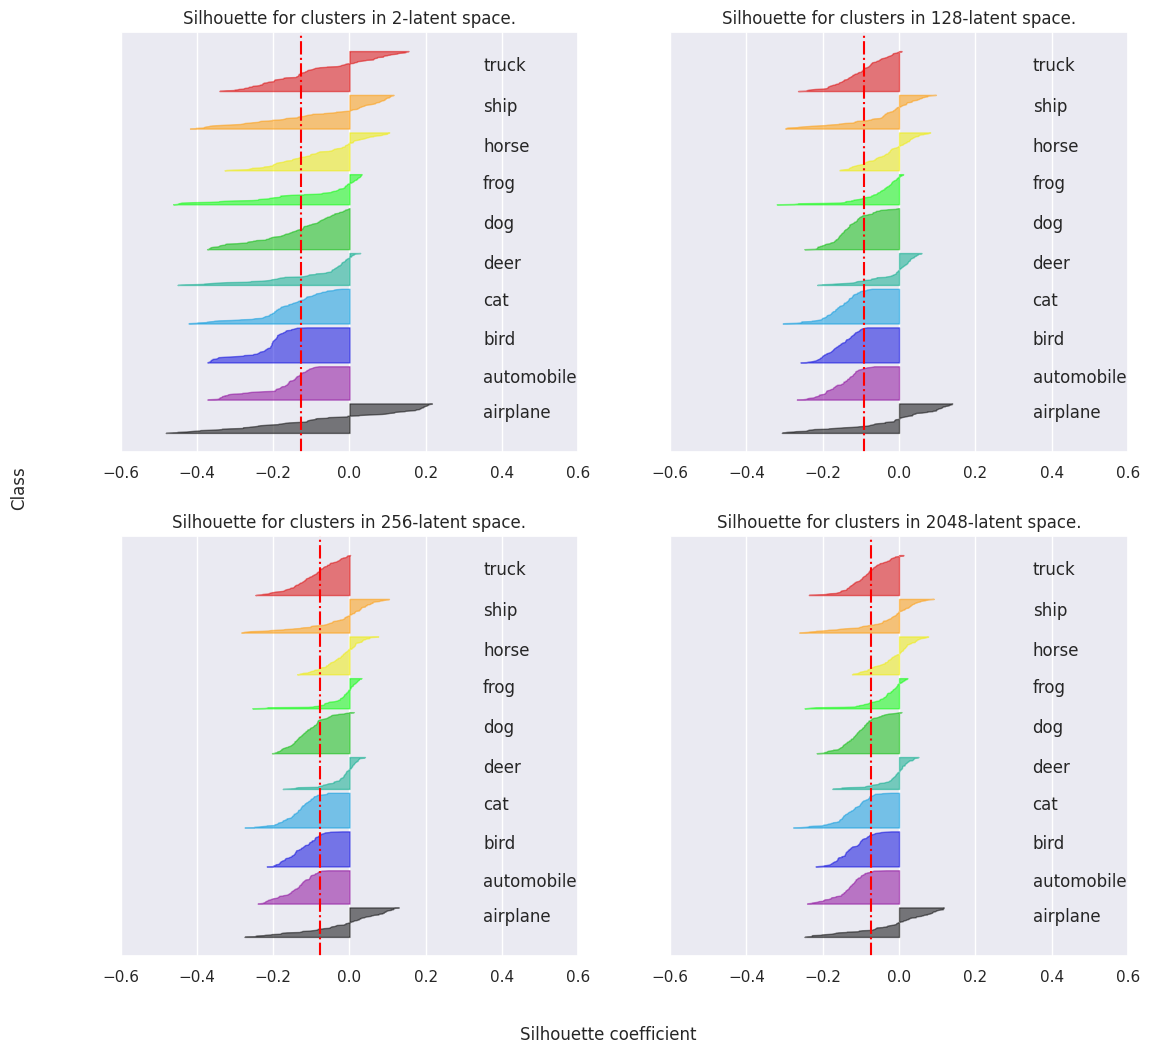

In [7]:
y_lower = 10
fig, ax = plt.subplots(2, 2,figsize=(13, 12))

for order, rank in enumerate([2, 128, 256, 2048]):

    for i in range(len(class_mapping)):
        
        ith_cluster_silhouette_values = per_sample_metric[order][label == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / len(class_mapping))

        ax[order//2][order%2].fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.5,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax[order//2][order%2].text(0.35, y_lower + 0.5 * size_cluster_i, class_mapping[i])

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax[order//2][order%2].set_title(f"Silhouette for clusters in {rank}-latent space.")

    # The vertical line for average silhouette score of all the values
    ax[order//2][order%2].axvline(x=metric[order] - 1, color="red", linestyle="-.")

    ax[order//2][order%2].set_yticks([])  # Clear the yaxis labels / ticks
    ax[order//2][order%2].set_xticks([ -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])


fig.text(0.5, 0.04, 'Silhouette chttps://intercambio.upv.es/upload.php?upv=1oefficient', ha='center')
fig.text(0.04, 0.5, 'Class', va='center', rotation='vertical')

plt.show()

